### Import Libraries

In [1]:
import os
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
from mplsoccer import Pitch, VerticalPitch

In [2]:
import socceraction.spadl as spadl
import socceraction.spadl.statsbomb as statsbomb
import socceraction.atomic.spadl as atomicspadl
import socceraction.spadl.config as spadlconfig

In [3]:
# matplotlib custom cmap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=[(0, 0, 0, 0),'darkgreen','lightgreen','yellow','orange','red']
)

### Utils functions

In [4]:
def play_left_to_right(actions, home_id):
    
    away_idx = (actions.team_id != home_id)
    for col in ['start_x', 'end_x']:
        actions.loc[away_idx, col]= spadlconfig.field_length - actions.loc[away_idx, col]
    for col in ['start_y','end_y']:
        actions.loc[away_idx, col]= spadlconfig.field_width - actions.loc[away_idx, col]
        
    return actions

In [5]:
def get_minutes_played(player_id, players):
    return players[players['player_id']==player_id]['minutes_played'].sum()

def is_above_threshold_minutes(player_id, minutes_played, threshold=450):
    if minutes_played >= threshold:
        return True
    return False

def per_90_norm(num_actions, player_minutes): 
    return round((90/player_minutes),2)*num_actions

In [507]:
# gaussian blur
def apply_gaussian_blur(action_matrix, sigma=1):
    return gaussian_filter(action_matrix, sigma)

# reshape multidimensional to 1 dimensional vector
def reshape_to_vector(matrix):
    return matrix.flatten()

In [7]:
def is_not_gk(player_id, players):
    position = players[players.player_id == player_id].starting_position_id.iloc[0]
    if position == 1:
        return False
    return True

In [449]:
def count_actions(action_df, bins=(50,50)):
    
    return scipy.stats.binned_statistic_2d(action_df.start_x, action_df.start_y, None, 'count', bins=bins, range=[[0, 105], [0, 68]])

def pitch_heatmap(binned_stats, ax):

    stats, x_edge, y_edge,_ = binned_stats
    
    x_grid, y_grid = np.meshgrid(x_edge, y_edge)

    stats = apply_gaussian_blur(stats.T,1)
    
    return ax.pcolormesh(x_grid, y_grid,stats,cmap=cmap)

In [450]:
stats, x,y,_= count_actions(passes)

In [451]:
stats.shape

(50, 50)

### Convert data stream to SPADL format

##### Load data from repository

In [9]:
# Use this if you only want to use the free public statsbomb data
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = statsbomb.StatsBombLoader(root=free_open_data_remote, getter="remote")

In [10]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 "Women's World Cup"}

In [11]:
# Select competition to load
selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]

In [12]:
# Get matches from all selected competitions
games = list(
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
games = pd.concat(games, sort=True).reset_index(drop=True)

##### Load events for selected competitions

In [13]:
# get all actions for all games in competition
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [],[]
actions = {}
atomic_actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    
    # convert data
    actions[game.game_id] = statsbomb.convert_to_actions(events, game.home_team_id)
    actions[game.game_id]['home_team_id'] = game.home_team_id
    actions[game.game_id]=play_left_to_right(actions[game.game_id], game.home_team_id)
    

actions = pd.concat(actions, ignore_index=True)
teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).reset_index(drop=True)


Loading game data: 100%|██████████| 194/194 [08:54<00:00,  2.75s/it]


In [14]:
# actions ids mapping
actions_ids = dict(spadl.actiontypes_df().values)

##### Group events per action type

In [15]:
# Group events per action type
events = actions[actions.type_id.isin([0,1,11,21])]

passes = events.groupby('type_id').get_group(0)
crosses = events.groupby('type_id').get_group(1)
shots = events.groupby('type_id').get_group(11)
dribbles = events.groupby('type_id').get_group(21)
#receiving = events.groupby('type_id').get_group(23)

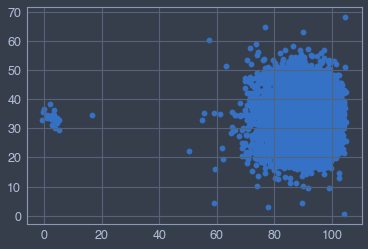

In [16]:
# test direction of play - all events should be clustered on one side of the pitch
plt.scatter(shots.start_x, shots.start_y,cmap=cmap)

### Classes

###### Class M

In [628]:
class BaseMatrix:
    
    def __init__(self):
        pass

class M:
    
    def __init__(self, l=50, w=50, threshold=450):
        
        self.l = l
        self.w = w
        self.threshold = threshold
        
        self.count = []
        self.players_ids = []
        self.players_edges = {}
        self.compressed_vectors = {}
        
        self.M = None
        self.W = None
        self.H = None
        
        self.evar = None
        self.sm = None
        
        self.components = None
        
        
    def build(self, df, players):
        
        for player_id in df.player_id.unique():
            
            num_minutes = get_minutes_played(player_id, players)
            
            if (num_minutes >= self.threshold) & (is_not_gk(player_id, players)):
                
                self.players_ids.append(player_id)
                
                player_df = df.groupby('player_id').get_group(player_id)
                
                stats, x_edge, y_edge, _ = count_actions(player_df,(self.l,self.w))
                
                if player_id not in self.players_edges.keys():
                    self.players_edges[player_id] = [x_edge, y_edge]
                
                norm_count = per_90_norm(stats, num_minutes)
                
                gaussian_matrix = apply_gaussian_blur(norm_count)
    
                player_vector = reshape_to_vector(gaussian_matrix)
        
                self.count.append(player_vector)
        
        self.M = np.array(self.count).T
        
    def to_dataframe(self):
        pass
    
    def heatmap_player(self, player_id):
        
        player_index = self.players_ids.index(player_id)
        
        x_edge, y_edge = self.players_edges[player_id]

        x_grid, y_grid = np.meshgrid(x_edge, y_edge)
        
        stats = self.M[player_index,:].reshape(self.l,self.w).T
        
        pitch = Pitch( pitch_type='custom', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef',pitch_length=105, pitch_width=68)
    
        fig, ax = pitch.draw(figsize=(6, 4))

        ax.pcolormesh(x_grid, y_grid, stats ,cmap=cmap)
    
    def apply_nmf(self, max_iter=200, components=5):
        
        self.components = components
        
        V = spr.csr_matrix(self.M)
        
        nmf = nimfa.Nmf(V, max_iter=max_iter, rank=components, update='euclidean', objective='fro')
        nmf_fit = nmf()
        
        self.W = nmf_fit.basis().todense()
        
        self.H = nmf_fit.coef().todense()
        
        self.evar = nmf.evar()
        
        self.sm = nmf_fit.summary()
        
        for player in self.players_ids:
            self.compressed_vectors[player] = self.compressed_vector_player(player)
        
        print('Euclidean distance: %5.3f' % nmf_fit.distance(metric='euclidean'))
        print('Sparseness Basis: %5.3f  Mixture: %5.3f' % (self.sm['sparseness'][0], self.sm['sparseness'][1]))
        print('Iterations: %d' % self.sm['n_iter'])
        print('Explained variance: %5.3f' % self.evar)
        
    
    def heatmap_type(self, component):
        
        stats = self.W[:,component].reshape(self.l,self.w)
        
        x_edge, y_edge = self.players_edges[list(self.players_edges.keys())[0]]

        x_grid, y_grid = np.meshgrid(x_edge, y_edge)
        
        pitch = Pitch( pitch_type='custom', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef',pitch_length=105, pitch_width=68)
    
        fig, ax = pitch.draw(figsize=(6, 4))

        ax.pcolormesh(x_grid,y_grid, stats ,cmap=cmap)
        
        
    def compressed_vector_player(self, player_id):
        
        player_index = self.players_ids.index(player_id)
        
        return np.array(self.H[:,player_index].flatten())[0]
        
        
    def heatmap_compressed_vector(self, player_id):
        
        player_index = self.players_ids.index(player_id)
        
        compressed_vector = self.H[:,player_index]
        
        stats = np.matmul(self.W, compressed_vector).reshape(self.l,self.w).T
        
        x_edge, y_edge = self.players_edges[player_id]

        x_grid, y_grid = np.meshgrid(x_edge, y_edge)
        
        pitch = Pitch( pitch_type='custom', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef',pitch_length=105, pitch_width=68)
    
        fig, ax = pitch.draw(figsize=(6,4))

        ax.pcolormesh(x_grid, y_grid, stats, cmap=cmap)
        
        #self.draw_pitch(self, x_grid, y_grid, stats)
        
        
    def draw_pitch(self, x_grid, y_grid, stats, cmap=cmap, size=(6,4)):
        
        pitch = Pitch( pitch_type='custom', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef',pitch_length=105, pitch_width=68)
    
        fig, ax = pitch.draw(figsize=size)

        ax.pcolormesh(x_grid, y_grid, stats, cmap=cmap)
        
        
        

##### Passes

In [629]:
passes_M = M()

In [630]:
passes_M.build(passes, players)

In [631]:
passes_M.apply_nmf(components=8)

Euclidean distance: 113.275
Sparseness Basis: 0.545  Mixture: 0.603
Iterations: 200
Explained variance: 0.651


##### Shots

In [607]:
shots_M = M()

In [608]:
shots_M.build(shots, players)

In [609]:
shots_M.apply_nmf(components=8)

Euclidean distance: 1.457
Sparseness Basis: 0.810  Mixture: 0.625
Iterations: 200
Explained variance: 0.609


##### Crosses

In [610]:
crosses_M = M()

In [611]:
crosses_M.build(crosses, players)

In [612]:
crosses_M.apply_nmf(components=8)

Euclidean distance: 1.181
Sparseness Basis: 0.832  Mixture: 0.644
Iterations: 200
Explained variance: 0.611


##### Dribbles

In [613]:
dribbles_M= M()

In [614]:
dribbles_M.build(dribbles, players)

In [615]:
dribbles_M.apply_nmf(components=8)

Euclidean distance: 116.011
Sparseness Basis: 0.541  Mixture: 0.604
Iterations: 200
Explained variance: 0.626


In [620]:
dribbles_M.players_ids[6:10]

[20034, 19418, 15613, 15631]

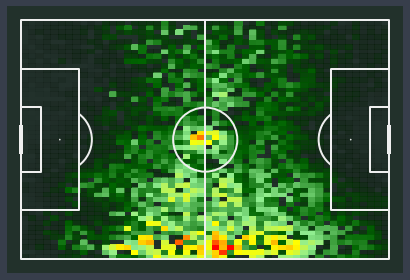

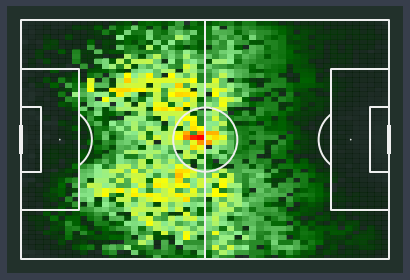

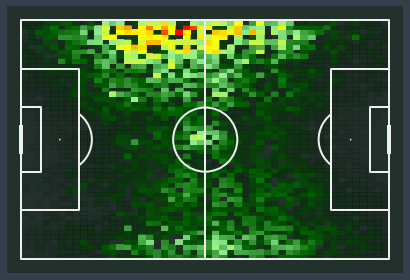

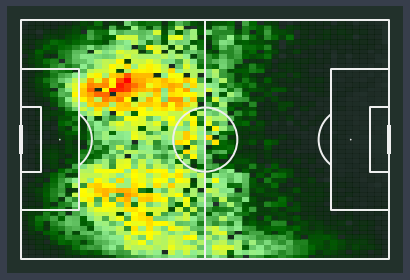

In [632]:
for player in passes_M.players_ids[6:10]:
    passes_M.heatmap_compressed_vector(player)

In [691]:
actions_M = [shots_M, passes_M, dribbles_M, crosses_M]

In [659]:
players_vectors = {}


for player in players.player_id.unique():
    for action in actions_M:
        if player not in action.players_ids:
            compressed_vector=np.zeros(8)
        else:
            compressed_vector = action.compressed_vectors[player]
            
        if player not in players_vectors.keys():
            players_vectors[player] = compressed_vector
        else:
            players_vectors[player] = np.concatenate((players_vectors[player], compressed_vector))


#### T-sne

In [681]:
X=pd.DataFrame(players_vectors).T.values

In [678]:
np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]]).shape

(4, 3)

In [682]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(4, 2)

In [689]:
data = pd.DataFrame(X_embedded, columns=['x','y'])

/Users/dbln/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

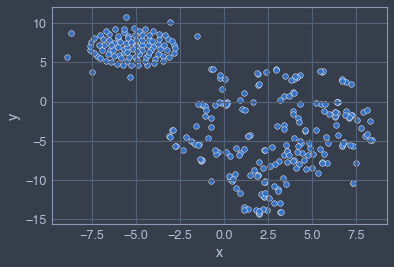

In [690]:
sns.scatterplot(data['x'], data['y'])

In [ ]:
class Player:
    
    def __init__(self, player_id):
        
        self.player_id = player_id
        self.vector = vector
        self.player_name = ''
        
        self.shot_vector = None
        self.cross_vector = None
        self.pass_vector = None
        self.dribble_vector = None
        
        
    
        
        
        
        